# Getting started

Thanks for checking out Salty! 

The purpose of Salty is to extend some of the machine learning ecosystem to ionic liquid (IL) data from [ILThermo](http://ilthermo.boulder.nist.gov/).

## Obtaining Smiles Strings

Salty operates using the simplified molecular-input line-entry system ([SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)). One of the core methods of Salty is the `check_name()` function that converts [IUPAC](https://iupac.org/) naming to Smiles:

In [1]:
import salty
smiles = salty.check_name("1-butyl-3-methylimidazolium")
print(smiles)

CCCCn1cc[n+](c1)C


once we have a smiles representation of a molecule, we can convert it into a molecular object with RDKit:

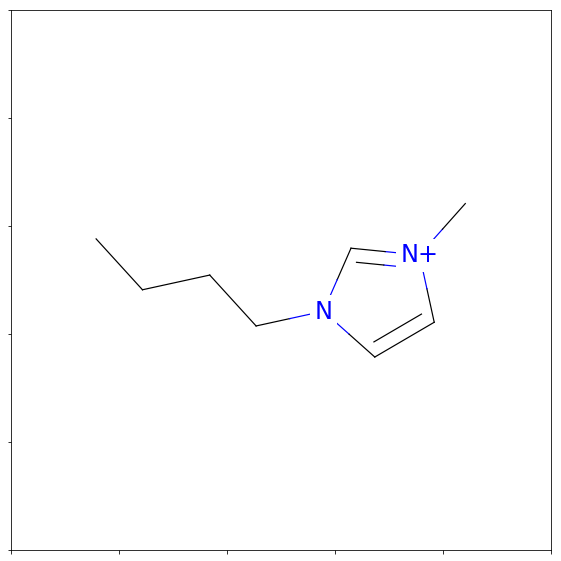

In [2]:
%matplotlib inline
from rdkit import Chem
from rdkit.Chem import Draw
fig = Draw.MolToMPL(Chem.MolFromSmiles(smiles),figsize=(5,5))

Once we have a molecular object, we can generate many kinds of bitvector representations or *fingerprints*.

Fingerprints can be used as descriptors in machine learning models, uncertainty estimators in structure search algorithms, or, as shown below, to simply compare two molecular structures:

In [3]:
ms = [Chem.MolFromSmiles("OC(=O)C(N)Cc1ccc(O)cc1"), Chem.MolFromSmiles(smiles)]
fig=Draw.MolsToGridImage(ms[:],molsPerRow=2,subImgSize=(400,200))
fig.save('compare.png')
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs

radius = 2

fpatom = [Pairs.GetAtomPairFingerprintAsBitVect(x) for x in ms]
print("atom pair score: {:8.4f}".format(DataStructs.TanimotoSimilarity(fpatom[0], fpatom[1])))
fpmorg = [AllChem.GetMorganFingerprint(ms[0],radius,useFeatures=True),
          AllChem.GetMorganFingerprint(ms[1],radius,useFeatures=True)]
fptopo = [FingerprintMols.FingerprintMol(x) for x in ms]
print("morgan score: {:11.4f}".format(DataStructs.TanimotoSimilarity(fpmorg[0], fpmorg[1])))
print("topological score: {:3.4f}".format(DataStructs.TanimotoSimilarity(fptopo[0], fptopo[1])))

atom pair score:   0.0513
morgan score:      0.0862
topological score: 0.3991


![](_static/compare.png)

`check_name` is based on a curated data file of known cations and anions

In [4]:
print("Cations in database: {}".format(len(salty.load_data("cationInfo.csv"))))
print("Anions in database:  {}".format(len(salty.load_data("anionInfo.csv"))))

Cations in database: 316
Anions in database:  125


## A Few Useful Datafiles

Salty contains some csv datafiles taken directly from ILThermo: heat capacity (constant pressure), density, and viscosity data for pure ILs. The `aggregate_data` function can be used to quickly manipulate these datafiles and append 2D features.

In [5]:
rawdata = salty.load_data("cpt.csv")
rawdata.columns

Index(['Heat capacity at constant pressure per unit volume, J/K/m<SUP>3</SUP>',
       'Heat capacity at constant pressure, J/K/mol',
       'Heat capacity at constant pressure<SUP>*</SUP>, J/K/mol',
       'Pressure, kPa', 'Temperature, K', 'salt_name'],
      dtype='object')

In [6]:
devmodel = salty.aggregate_data(['cpt', 'density']) # other option is viscosity

`aggregate_data` returns a devmodel object that contains a pandas dataframe of the raw data and a data summary:

In [7]:
devmodel.Data_summary

,0
Unique salts,109
Cations,"array(['CCCC[n+]1ccc(cc1)C', 'CCCCCCCCn1cc[n+]..."
Anions,"array(['[B-](F)(F)(F)F', 'F[P-](F)(F)(F)(F)F',..."
Total datapoints,7834
density,847.5 - 1557.1
cpt,207.47 - 1764.0
Temperature range (K),100.0 - 60000.0
Pressure range (kPa),273.15 - 463.15


and has scaled and centered 2D features from [rdkit](http://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors):

In [8]:
devmodel.Data.columns

Index(['steiger-anion', 'Marsili Partial Charges-anion', 'BalabanJ-anion',
       'BertzCT-anion', 'Ipc-anion', 'HallKierAlpha-anion', 'Kappa1-anion',
       'Kappa2-anion', 'Kappa3-anion', 'Chi0-anion',
       ...
       'VSA_EState10-cation', 'Topliss fragments-cation', 'Temperature, K',
       'Pressure, kPa', 'Heat capacity at constant pressure, J/K/mol',
       'Specific density, kg/m<SUP>3</SUP>', 'name-anion', 'smiles-anion',
       'name-cation', 'smiles-cation'],
      dtype='object', length=196)

The purpose of the data summary is to provide historical information when ML models are ported over into [GAINS](https://wesleybeckner.github.io/gains/). Once we have a devmodel the underlying data can be interrogated:

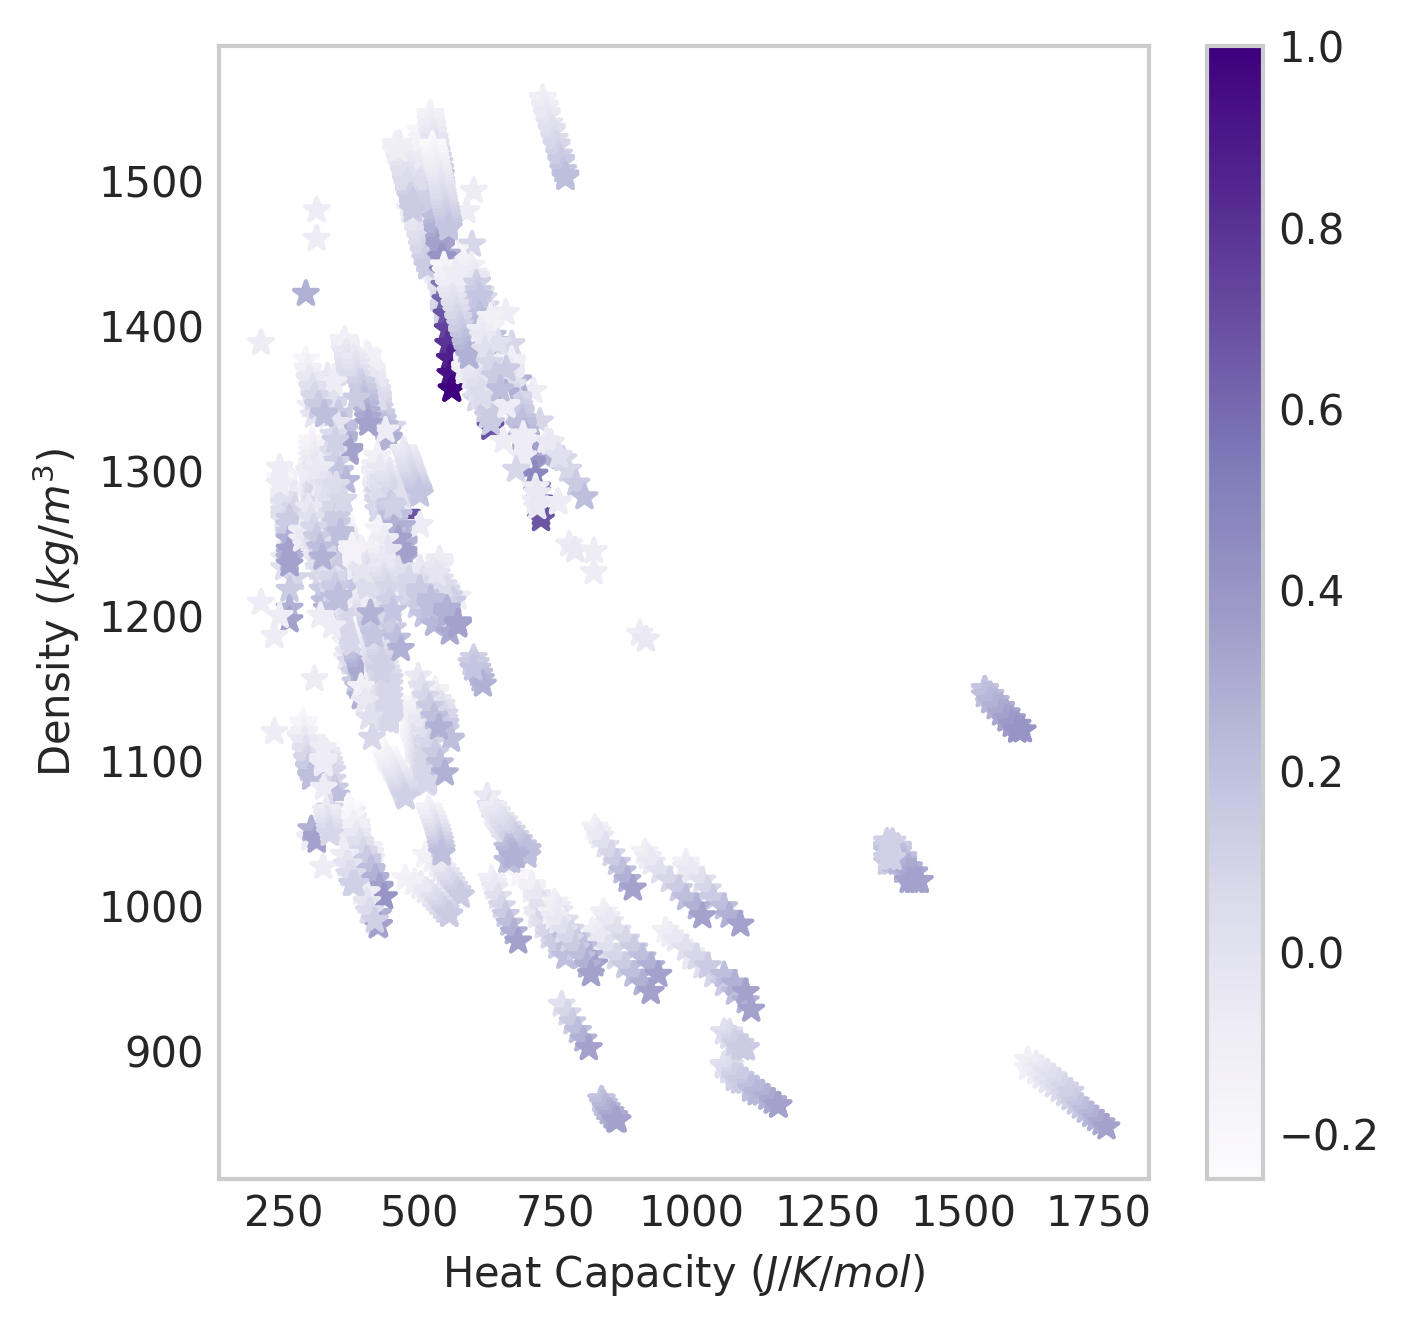

In [9]:
import matplotlib.pyplot as plt
import numpy as np
df = devmodel.Data
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    scat = ax.scatter(np.exp(df["Heat capacity at constant pressure, J/K/mol"]), np.exp(
        df["Specific density, kg/m<SUP>3</SUP>"]),
        marker="*", c=df["Temperature, K"]/max(df["Temperature, K"]), cmap="Purples")
    plt.colorbar(scat)
    ax.grid()
    ax.set_ylabel("Density $(kg/m^3)$")
    ax.set_xlabel("Heat Capacity $(J/K/mol)$")

## Build Models with Scikit-Learn

Salty's `devmodel_to_array` function automatically detects the number of targets in the devmodel and creates train/test arrays accordingly:

In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
model = MLPRegressor(activation='relu', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1e8, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)
multi_model = MultiOutputRegressor(model)
X_train, Y_train, X_test, Y_test = salty.devmodel_to_array\
                                   (devmodel, train_fraction=0.8)
multi_model.fit(X_train, Y_train)

MultiOutputRegressor(estimator=MLPRegressor(activation='relu', alpha=0.92078, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000000.0, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False),
           n_jobs=1)

We can then see how the model is performing with matplotlib:

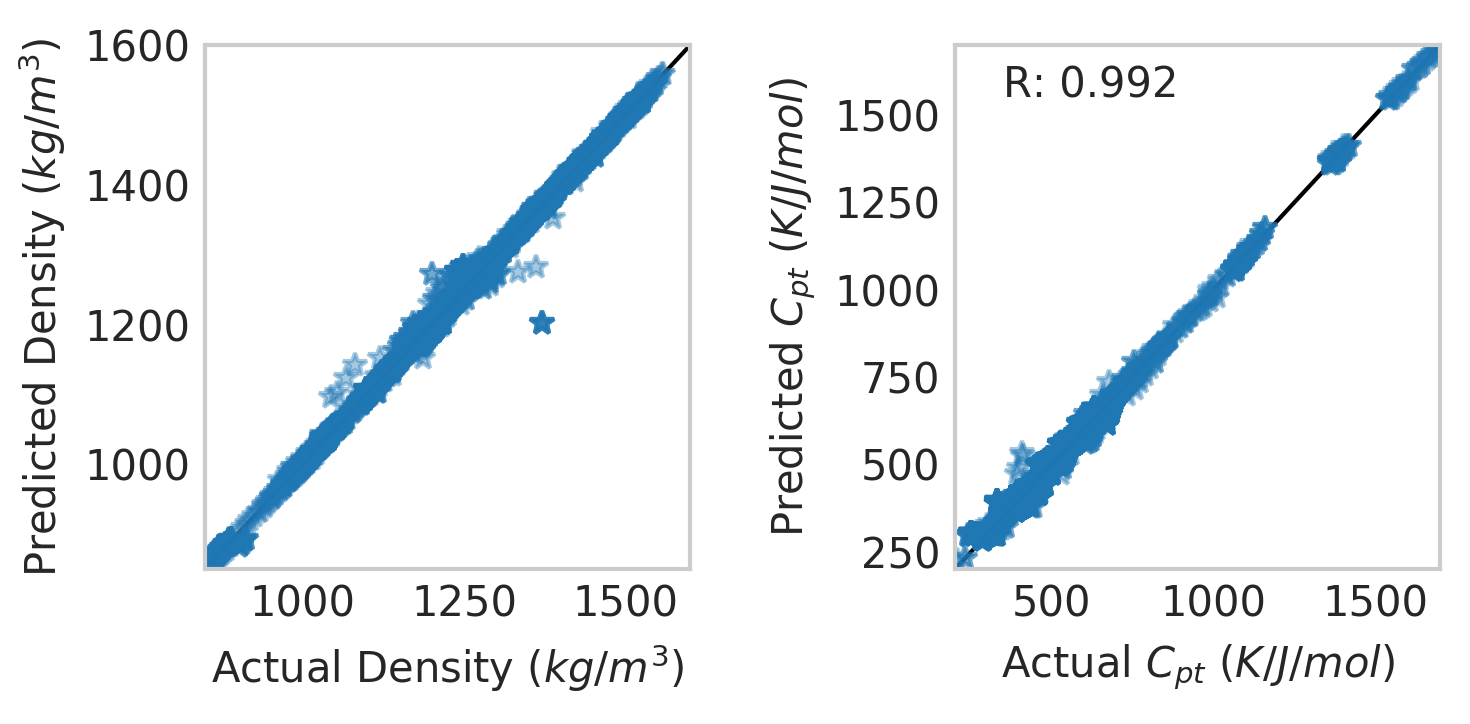

In [24]:
X=X_train
Y=Y_train
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,2.5), dpi=300)
    ax=fig.add_subplot(122)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:,0],np.exp(multi_model.predict(X))[:,0],\
            marker="*",linestyle="",alpha=0.4)
    ax.set_ylabel("Predicted $C_{pt}$ $(K/J/mol)$")
    ax.set_xlabel("Actual $C_{pt}$ $(K/J/mol)$")
    ax.text(0.1,.9,"R: {0:5.3f}".format(multi_model.score(X,Y)), transform = ax.transAxes)
    plt.xlim(200,1700)
    plt.ylim(200,1700)
    ax.grid()
    ax=fig.add_subplot(121)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:,1],np.exp(multi_model.predict(X))[:,1],\
            marker="*",linestyle="",alpha=0.4)
    
    ax.set_ylabel("Predicted Density $(kg/m^3)$")
    ax.set_xlabel("Actual Density $(kg/m^3)$")
    plt.xlim(850,1600)
    plt.ylim(850,1600)
    ax.grid()
    plt.tight_layout()

## Build Models with Keras

The above sklearn model has a very simple architecture (1 hidden layer with 75 nodes) we can recreate this in Keras:

In [74]:
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.optimizers import Nadam

X_train, Y_train, X_test, Y_test = salty.devmodel_to_array\
    (devmodel, train_fraction=0.8)
model = Sequential()
model.add(Dense(75, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(2, activation='linear'))
model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=['mse'])
model.fit(X_train,Y_train,epochs=1000,verbose=True)

Epoch 1/1000
6267/6267 [==============================] - 1s 153us/step - loss: 11.3768 - mean_squared_error: 11.3768
Epoch 2/1000
6267/6267 [==============================] - 1s 87us/step - loss: 3.3453 - mean_squared_error: 3.3453
Epoch 3/1000
6267/6267 [==============================] - 1s 87us/step - loss: 2.6360 - mean_squared_error: 2.6360
Epoch 4/1000
6267/6267 [==============================] - 1s 83us/step - loss: 2.2576 - mean_squared_error: 2.2576
Epoch 5/1000
6267/6267 [==============================] - 1s 94us/step - loss: 1.9808 - mean_squared_error: 1.9808
Epoch 6/1000
6267/6267 [==============================] - 1s 87us/step - loss: 1.7769 - mean_squared_error: 1.7769
Epoch 7/1000
6267/6267 [==============================] - 0s 77us/step - loss: 1.6379 - mean_squared_error: 1.6379
Epoch 8/1000
6267/6267 [==============================] - 1s 80us/step - loss: 1.5387 - mean_squared_error: 1.5387
Epoch 9/1000
6267/6267 [==============================] - 0s 71us/step - loss

6267/6267 [==============================] - 0s 70us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 140/1000
6267/6267 [==============================] - 0s 66us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 141/1000
6267/6267 [==============================] - 0s 74us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 142/1000
6267/6267 [==============================] - 0s 78us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 143/1000
6267/6267 [==============================] - 0s 67us/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 144/1000
6267/6267 [==============================] - 0s 76us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 145/1000
6267/6267 [==============================] - 1s 81us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 146/1000
6267/6267 [==============================] - 1s 81us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 147/1000
6267/6267 [==============================] - 0s 78us/step - loss

6267/6267 [==============================] - 0s 80us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 279/1000
6267/6267 [==============================] - 0s 76us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 280/1000
6267/6267 [==============================] - 1s 107us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 281/1000
6267/6267 [==============================] - 0s 74us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 282/1000
6267/6267 [==============================] - 0s 74us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 283/1000
6267/6267 [==============================] - 0s 78us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 284/1000
6267/6267 [==============================] - 1s 82us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 285/1000
6267/6267 [==============================] - 1s 88us/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 286/1000
6267/6267 [==============================] - 1s 92us/step - los

6267/6267 [==============================] - 0s 58us/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 417/1000
6267/6267 [==============================] - 0s 59us/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 418/1000
6267/6267 [==============================] - 0s 57us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 419/1000
6267/6267 [==============================] - 0s 58us/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 420/1000
6267/6267 [==============================] - 0s 68us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 421/1000
6267/6267 [==============================] - 0s 65us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 422/1000
6267/6267 [==============================] - 0s 58us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 423/1000
6267/6267 [==============================] - 0s 58us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 424/1000
6267/6267 [==============================] - 0s 73us/step - loss

6267/6267 [==============================] - 0s 75us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 556/1000
6267/6267 [==============================] - 0s 71us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 557/1000
6267/6267 [==============================] - 0s 65us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 558/1000
6267/6267 [==============================] - 0s 77us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 559/1000
6267/6267 [==============================] - 1s 80us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 560/1000
6267/6267 [==============================] - 0s 71us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 561/1000
6267/6267 [==============================] - 0s 67us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 562/1000
6267/6267 [==============================] - 0s 69us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 563/1000
6267/6267 [==============================] - 0s 75us/step - loss

6267/6267 [==============================] - 1s 99us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 626/1000
6267/6267 [==============================] - 1s 95us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 627/1000
6267/6267 [==============================] - 1s 94us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 628/1000
6267/6267 [==============================] - 1s 82us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 629/1000
6267/6267 [==============================] - 0s 77us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 630/1000
6267/6267 [==============================] - 1s 103us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 631/1000
6267/6267 [==============================] - 1s 84us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 632/1000
6267/6267 [==============================] - 0s 72us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 633/1000
6267/6267 [==============================] - 1s 109us/step - lo

6267/6267 [==============================] - 0s 76us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 696/1000
6267/6267 [==============================] - 0s 73us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 697/1000
6267/6267 [==============================] - 0s 69us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 698/1000
6267/6267 [==============================] - 0s 69us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 699/1000
6267/6267 [==============================] - 1s 85us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 700/1000
6267/6267 [==============================] - 0s 80us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 701/1000
6267/6267 [==============================] - 0s 66us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 702/1000
6267/6267 [==============================] - 0s 67us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 703/1000
6267/6267 [==============================] - 0s 74us/step - loss

6267/6267 [==============================] - 0s 59us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 835/1000
6267/6267 [==============================] - 0s 59us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 836/1000
6267/6267 [==============================] - 0s 64us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 837/1000
6267/6267 [==============================] - 0s 59us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 838/1000
6267/6267 [==============================] - 0s 59us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 839/1000
6267/6267 [==============================] - 0s 59us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 840/1000
6267/6267 [==============================] - 0s 62us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 841/1000
6267/6267 [==============================] - 0s 67us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 842/1000
6267/6267 [==============================] - 0s 69us/step - loss

6267/6267 [==============================] - 0s 58us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 975/1000
6267/6267 [==============================] - 0s 59us/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 976/1000
6267/6267 [==============================] - 0s 57us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 977/1000
6267/6267 [==============================] - 0s 58us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 978/1000
6267/6267 [==============================] - 0s 59us/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 979/1000
6267/6267 [==============================] - 0s 58us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 980/1000
6267/6267 [==============================] - 0s 58us/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 981/1000
6267/6267 [==============================] - 0s 58us/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 982/1000
6267/6267 [==============================] - 0s 57us/step - loss

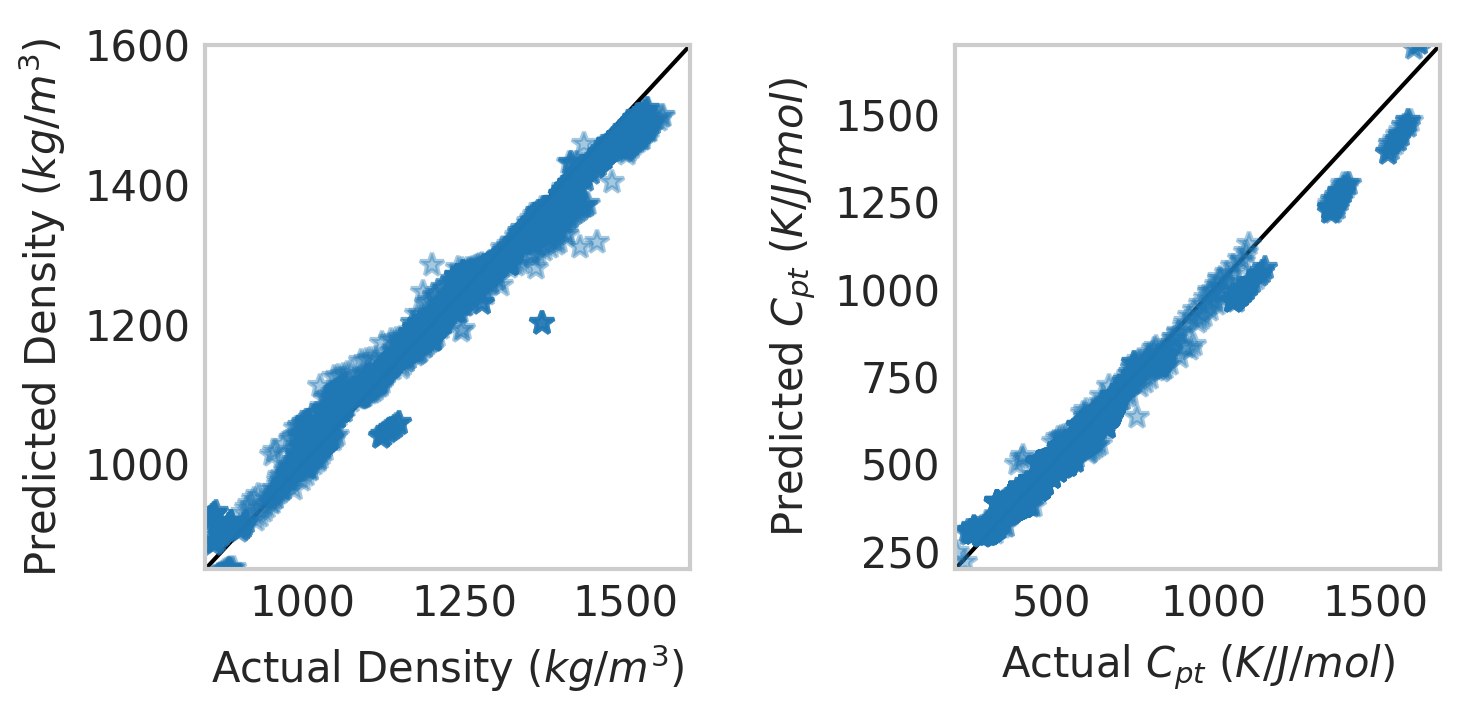

In [76]:
X=X_train
Y=Y_train
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,2.5), dpi=300)
    ax=fig.add_subplot(122)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:,0],np.exp(model.predict(X))[:,0],\
            marker="*",linestyle="",alpha=0.4)
    ax.set_ylabel("Predicted $C_{pt}$ $(K/J/mol)$")
    ax.set_xlabel("Actual $C_{pt}$ $(K/J/mol)$")
    #ax.text(0.1,.9,"R: {0:5.3f}".format(multi_model.score(X,Y)), transform = ax.transAxes)
    plt.xlim(200,1700)
    plt.ylim(200,1700)
    ax.grid()
    ax=fig.add_subplot(121)
    ax.plot([0,2000], [0,2000], linestyle="-", label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:,1],np.exp(model.predict(X))[:,1],\
            marker="*",linestyle="",alpha=0.4)
    
    ax.set_ylabel("Predicted Density $(kg/m^3)$")
    ax.set_xlabel("Actual Density $(kg/m^3)$")
    plt.xlim(850,1600)
    plt.ylim(850,1600)
    ax.grid()
    plt.tight_layout()

In [10]:
from keras.models import load_model

model = load_model("density_keras_qspr.h5")

/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
model.save("density_keras_qspr.h5")

# Save Models for GAINS

In [60]:
model.save('cpt_density_keras_qspr.sav')

In [48]:
def update_summary(devmodel, model): # we can optionally include the details of the NN
    summary = devmodel.Data_summary
    a = pd.DataFrame.from_dict(model.get_params(), orient='index')
    b = pd.DataFrame([model.score(X_train,Y_train)], columns=["train score"])
    c = pd.DataFrame([model.score(X_test,Y_test)], columns=["test score"])
    summary = pd.concat([summary, a, b.T, c.T])
    return summary

summary = devmodel.Data_summary
descriptors = devmodel.Coef_data
qspr = salty.qspr_model(model, summary, descriptors)

In [57]:
import dill
import sys
sys.setrecursionlimit(100000)
dill_out = open("../salty/data/MODELS/cpt_density_qspr_keras.sav", "wb")
dill.dump(qspr, dill_out)
dill_out.close()

TypeError: can't pickle _thread._local objects

These are all the basic Salty functions for now!

In [63]:
import h5py

In [64]:

f = h5py.File("mytestfile.hdf5", "w")
with h5py.File("mytestfile.hdf5", "w") as f:
    dset = f.create_dataset("mydataset", (100,), dtype='i')

In [32]:
import salty
import dill
import pandas as pd
model = salty.load_model("viscosity_m1.sav")
summary = pd.read_csv("../salty/data/MODELS/viscosity_m1_summary.csv")
descriptors = salty.load_data("MODELS/viscosity_m1_descriptors.csv")
qspr = salty.qspr_model(model, summary, descriptors)
dill_out = open("../salty/data/MODELS/viscosity_qspr.sav", "wb")
dill.dump(qspr, dill_out)
dill_out.close()

/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
